In [8]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

%matplotlib inline

# Configuration
main_dir = os.getcwd() + '\\'
data_extended_name = main_dir + 'match_vectors_extended.csv'
ratio = 0.8

FEATURE_LABEL = [
    'h_roster_rating', 'h_gk_rating', 'h_def_rating', 'h_mid_rating', 'h_off_rating',
    'a_roster_rating', 'a_gk_rating', 'a_def_rating', 'a_mid_rating', 'a_off_rating', 'label'
]

In [9]:
# Cell 2: Visualization Functions
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot confusion matrix with heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Loss', 'Draw', 'Win'],
                yticklabels=['Loss', 'Draw', 'Win'])
    plt.title(f'{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_accuracy_comparison(train_accuracies, test_accuracies, nodes_range, title='NN Accuracy vs Hidden Nodes'):
    """Plot training and test accuracy across different hidden nodes"""
    plt.figure(figsize=(12, 6))
    
    plt.plot(nodes_range, train_accuracies, 'bo-', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(nodes_range, test_accuracies, 'ro-', label='Test Accuracy', linewidth=2, markersize=8)
    
    plt.xlabel('Number of Hidden Nodes')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(nodes_range)
    
    # Annotate the best test accuracy
    best_idx = np.argmax(test_accuracies)
    best_nodes = nodes_range[best_idx]
    best_accuracy = test_accuracies[best_idx]
    
    plt.annotate(f'Best: {best_accuracy:.3f} at {best_nodes} nodes', 
                xy=(best_nodes, best_accuracy),
                xytext=(best_nodes, best_accuracy + 0.05),
                arrowprops=dict(arrowstyle='->', color='red'),
                ha='center')
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, title='Predictions vs Actual'):
    """Plot predicted vs actual values"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Scatter plot of predictions vs actual
    ax1.scatter(range(len(y_true)), y_true, alpha=0.7, label='Actual', color='blue')
    ax1.scatter(range(len(y_pred)), y_pred, alpha=0.7, label='Predicted', color='red')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Class')
    ax1.set_title(f'{title} - Values')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error distribution
    errors = y_pred - y_true
    ax2.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Prediction Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{title} - Error Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Cell 3: Utility Functions
def gen_quadratic_features(X):
    """Generate quadratic features from input data"""
    new_features = []
    for i in range(len(X)):
        x = X[i]
        y = np.outer(x, x)
        y_flat = y.flatten()
        x_extended = np.append(x, y_flat)
        new_features.append(x_extended)
    
    print(f"Quadratic features shape: {np.shape(new_features)}")
    return np.array(new_features)

def print_detailed_metrics(y_true, y_pred, dataset_name):
    """Print comprehensive classification metrics"""
    print(f"\n{'='*60}")
    print(f"RESULTS FOR {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Basic accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Loss', 'Draw', 'Win']))
    
    # Per-class accuracy
    unique_labels = np.unique(y_true)
    print("\nPer-class Accuracy:")
    for label in unique_labels:
        mask = y_true == label
        class_accuracy = np.sum(y_pred[mask] == label) / np.sum(mask)
        label_name = ['Loss', 'Draw', 'Win'][int(label) + 1] if label in [-1, 0, 1] else str(label)
        print(f"  {label_name}: {class_accuracy:.4f}")
    
    return accuracy, cm

In [11]:
# Cell 4: Main Neural Network Training Function
def train_neural_network(X_training, y_training, X_test, y_test, nodes_range=range(9, 20)):
    """Train MLP classifier with different hidden node configurations"""
    
    train_accuracies = []
    test_accuracies = []
    best_accuracy = 0
    best_model = None
    best_nodes = None
    
    print("Training Neural Network with different hidden layer sizes...")
    print(f"Testing hidden nodes: {list(nodes_range)}")
    print(f"Training samples: {len(X_training)}, Test samples: {len(X_test)}")
    
    for n_nodes in nodes_range:
        print(f"\n{'─'*50}")
        print(f"Training with {n_nodes} hidden nodes")
        print(f"{'─'*50}")
        
        # Initialize and train classifier
        clf = MLPClassifier(
            solver='sgd', 
            alpha=2, 
            activation='tanh', 
            hidden_layer_sizes=(n_nodes), 
            max_iter=20000,
            random_state=42
        )
        
        clf.fit(X_training, y_training)
        
        # Test set predictions and metrics
        test_predictions = clf.predict(X_test)
        test_accuracy = np.sum(test_predictions == y_test) / len(y_test)
        test_accuracies.append(test_accuracy)
        
        print(f"TEST SET - {n_nodes} nodes:")
        test_accuracy_val, test_cm = print_detailed_metrics(y_test, test_predictions, f"Test Set ({n_nodes} nodes)")
        plot_confusion_matrix(y_test, test_predictions, f'Test Set - {n_nodes} Nodes')
        
        # Training set predictions and metrics
        train_predictions = clf.predict(X_training)
        train_accuracy = np.sum(train_predictions == y_training) / len(y_training)
        train_accuracies.append(train_accuracy)
        
        print(f"\nTRAINING SET - {n_nodes} nodes:")
        train_accuracy_val, train_cm = print_detailed_metrics(y_training, train_predictions, f"Training Set ({n_nodes} nodes)")
        plot_confusion_matrix(y_training, train_predictions, f'Training Set - {n_nodes} Nodes')
        
        # Plot predictions vs actual for test set
        plot_predictions_vs_actual(y_test, test_predictions, f'Test Set Predictions - {n_nodes} Nodes')
        
        # Track best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = clf
            best_nodes = n_nodes
    
    return train_accuracies, test_accuracies, best_model, best_nodes, best_accuracy

In [12]:
# Cell 5: Data Loading and Preprocessing
def load_and_preprocess_data(data_file):
    """Load and preprocess the dataset"""
    print("Loading and preprocessing data...")
    
    # Load data
    data = shuffle(np.genfromtxt(data_file, delimiter=',', skip_header=1), random_state=0)
    print(f"Original data shape: {data.shape}")
    
    # Separate features and labels
    X = data[:, :-1]
    y = data[:, -1]
    
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Label distribution: {np.unique(y, return_counts=True)}")
    
    # Split data
    i_split = int(len(y) * ratio)
    X_training = X[:i_split]
    y_training = y[:i_split]
    X_test = X[i_split:]
    y_test = y[i_split:]
    
    print(f"Training set: {X_training.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_training_scaled = scaler.fit_transform(X_training)
    X_test_scaled = scaler.transform(X_test)
    
    print("Feature scaling completed")
    
    return X_training_scaled, y_training, X_test_scaled, y_test, scaler

In [13]:
# Cell 6: Main Execution
def main(data_file):
    """Main function to run neural network training and evaluation"""
    
    # Load and preprocess data
    X_training, y_training, X_test, y_test, scaler = load_and_preprocess_data(data_file)
    
    # Define nodes range to test
    nodes_range = range(9, 20)
    
    # Train neural networks
    train_accuracies, test_accuracies, best_model, best_nodes, best_accuracy = train_neural_network(
        X_training, y_training, X_test, y_test, nodes_range
    )
    
    # Plot accuracy comparison
    plot_accuracy_comparison(
        train_accuracies, test_accuracies, list(nodes_range),
        'Neural Network Accuracy vs Hidden Layer Size'
    )
    
    # Final summary
    print(f"\n{'='*80}")
    print("FINAL SUMMARY")
    print(f"{'='*80}")
    print(f"Best Model: {best_nodes} hidden nodes")
    print(f"Best Test Accuracy: {best_accuracy:.4f}")
    print(f"Training Accuracy Range: {min(train_accuracies):.4f} - {max(train_accuracies):.4f}")
    print(f"Test Accuracy Range: {min(test_accuracies):.4f} - {max(test_accuracies):.4f}")
    
    # Check for overfitting
    overfitting_gap = max(train_accuracies) - max(test_accuracies)
    print(f"Overfitting Gap: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("⚠️  Warning: Potential overfitting detected!")
    else:
        print("✅ Model generalization appears good")
    
    return best_model, scaler, train_accuracies, test_accuracies

Starting Neural Network Analysis for EPL Predictions
Loading and preprocessing data...
Original data shape: (3791, 281)
Features shape: (3791, 280)
Labels shape: (3791,)
Label distribution: (array([-1.,  0.,  1.]), array([1100,  940, 1751]))
Training set: 3032 samples
Test set: 759 samples
Feature scaling completed
Training Neural Network with different hidden layer sizes...
Testing hidden nodes: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Training samples: 3032, Test samples: 759

──────────────────────────────────────────────────
Training with 9 hidden nodes
──────────────────────────────────────────────────
TEST SET - 9 nodes:

RESULTS FOR TEST SET (9 NODES)
Overall Accuracy: 0.5310

Confusion Matrix:
[[112  39  60]
 [ 56  43  94]
 [ 47  60 248]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.52      0.53      0.53       211
        Draw       0.30      0.22      0.26       193
         Win       0.62      0.70      0.66 

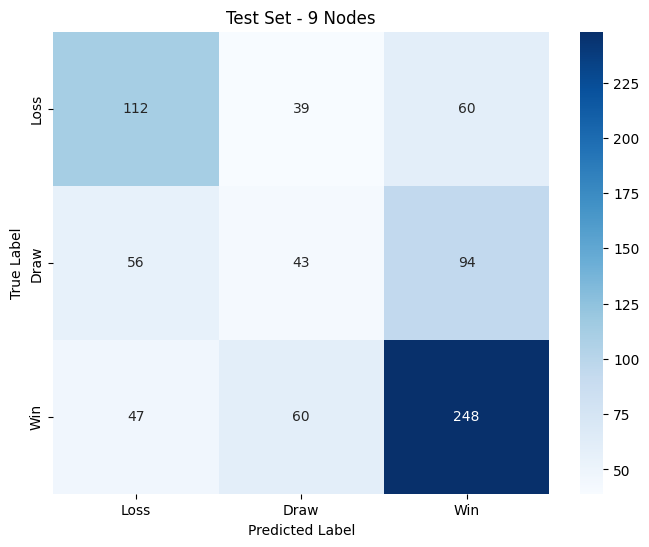


TRAINING SET - 9 nodes:

RESULTS FOR TRAINING SET (9 NODES)
Overall Accuracy: 0.7708

Confusion Matrix:
[[ 684   82  123]
 [ 140  394  213]
 [  87   50 1259]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.75      0.77      0.76       889
        Draw       0.75      0.53      0.62       747
         Win       0.79      0.90      0.84      1396

    accuracy                           0.77      3032
   macro avg       0.76      0.73      0.74      3032
weighted avg       0.77      0.77      0.76      3032


Per-class Accuracy:
  Loss: 0.7694
  Draw: 0.5274
  Win: 0.9019


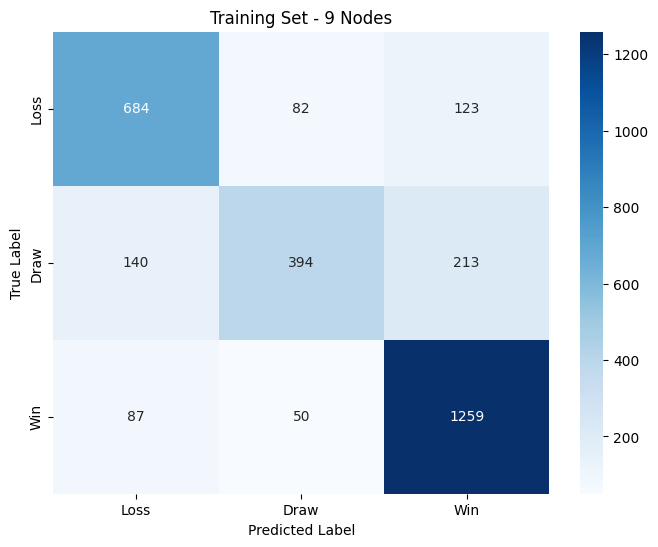

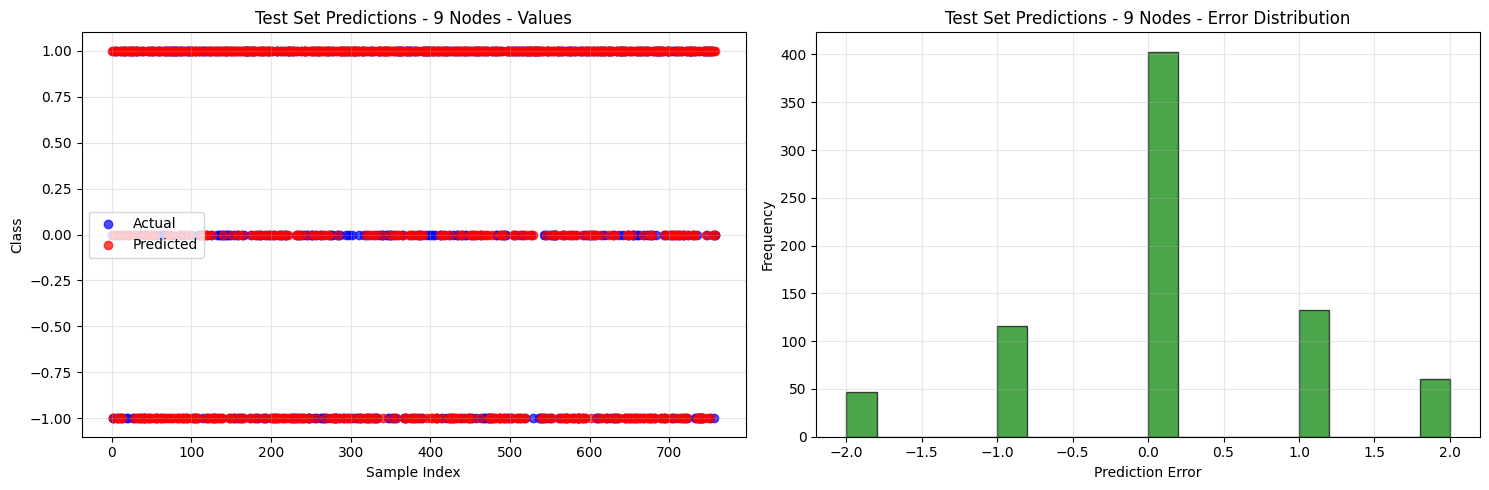


──────────────────────────────────────────────────
Training with 10 hidden nodes
──────────────────────────────────────────────────
TEST SET - 10 nodes:

RESULTS FOR TEST SET (10 NODES)
Overall Accuracy: 0.5349

Confusion Matrix:
[[106  32  73]
 [ 58  48  87]
 [ 50  53 252]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.50      0.50      0.50       211
        Draw       0.36      0.25      0.29       193
         Win       0.61      0.71      0.66       355

    accuracy                           0.53       759
   macro avg       0.49      0.49      0.48       759
weighted avg       0.52      0.53      0.52       759


Per-class Accuracy:
  Loss: 0.5024
  Draw: 0.2487
  Win: 0.7099


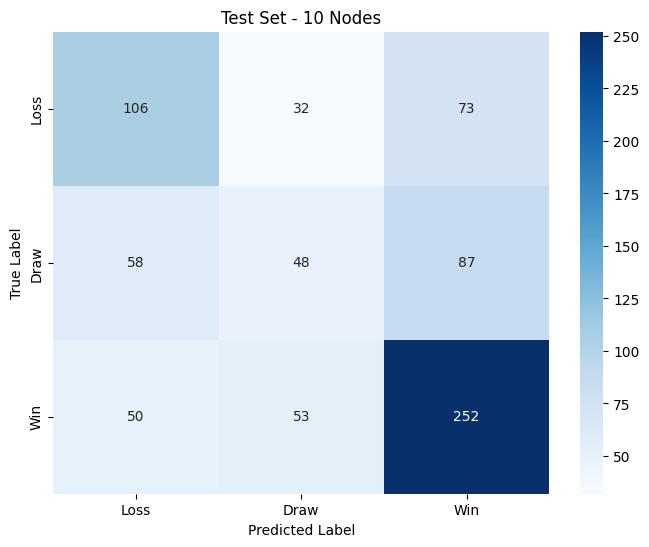


TRAINING SET - 10 nodes:

RESULTS FOR TRAINING SET (10 NODES)
Overall Accuracy: 0.7794

Confusion Matrix:
[[ 729   55  105]
 [ 110  396  241]
 [  86   72 1238]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.79      0.82      0.80       889
        Draw       0.76      0.53      0.62       747
         Win       0.78      0.89      0.83      1396

    accuracy                           0.78      3032
   macro avg       0.78      0.75      0.75      3032
weighted avg       0.78      0.78      0.77      3032


Per-class Accuracy:
  Loss: 0.8200
  Draw: 0.5301
  Win: 0.8868


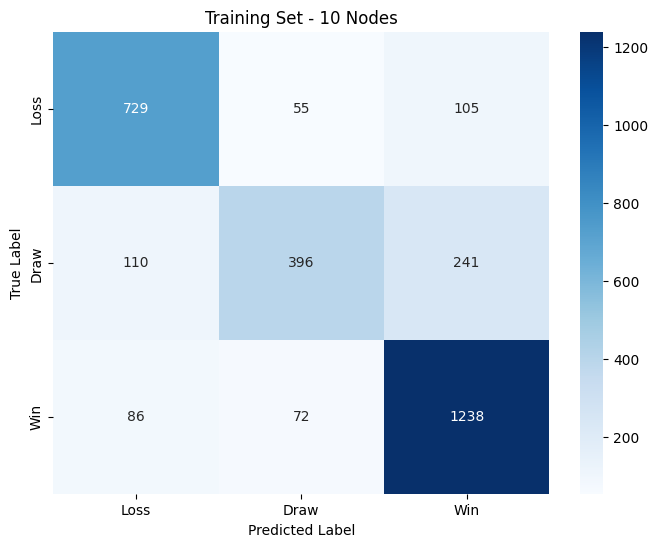

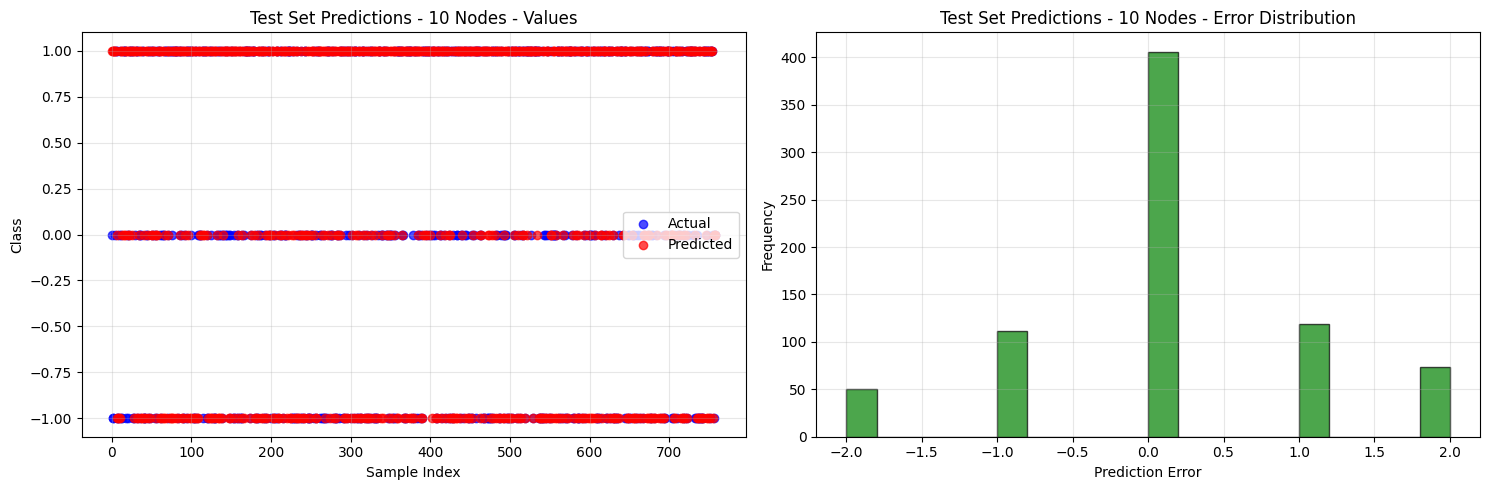


──────────────────────────────────────────────────
Training with 11 hidden nodes
──────────────────────────────────────────────────
TEST SET - 11 nodes:

RESULTS FOR TEST SET (11 NODES)
Overall Accuracy: 0.5270

Confusion Matrix:
[[111  31  69]
 [ 62  44  87]
 [ 49  61 245]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.50      0.53      0.51       211
        Draw       0.32      0.23      0.27       193
         Win       0.61      0.69      0.65       355

    accuracy                           0.53       759
   macro avg       0.48      0.48      0.48       759
weighted avg       0.51      0.53      0.51       759


Per-class Accuracy:
  Loss: 0.5261
  Draw: 0.2280
  Win: 0.6901


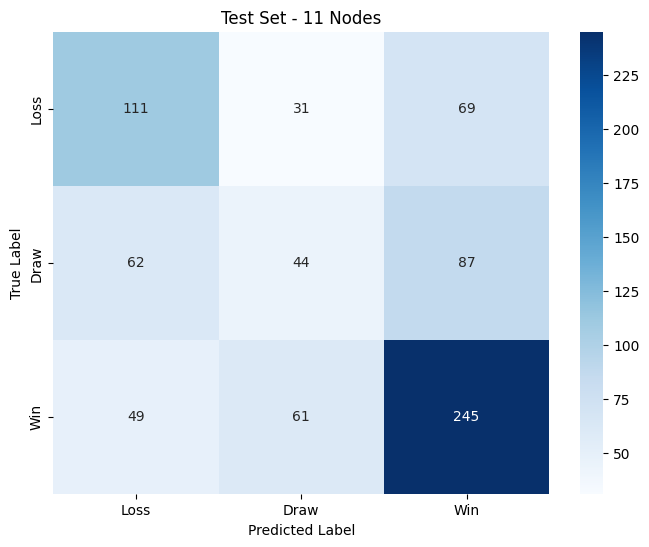


TRAINING SET - 11 nodes:

RESULTS FOR TRAINING SET (11 NODES)
Overall Accuracy: 0.8018

Confusion Matrix:
[[ 725   76   88]
 [ 131  425  191]
 [  59   56 1281]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.79      0.82      0.80       889
        Draw       0.76      0.57      0.65       747
         Win       0.82      0.92      0.87      1396

    accuracy                           0.80      3032
   macro avg       0.79      0.77      0.77      3032
weighted avg       0.80      0.80      0.80      3032


Per-class Accuracy:
  Loss: 0.8155
  Draw: 0.5689
  Win: 0.9176


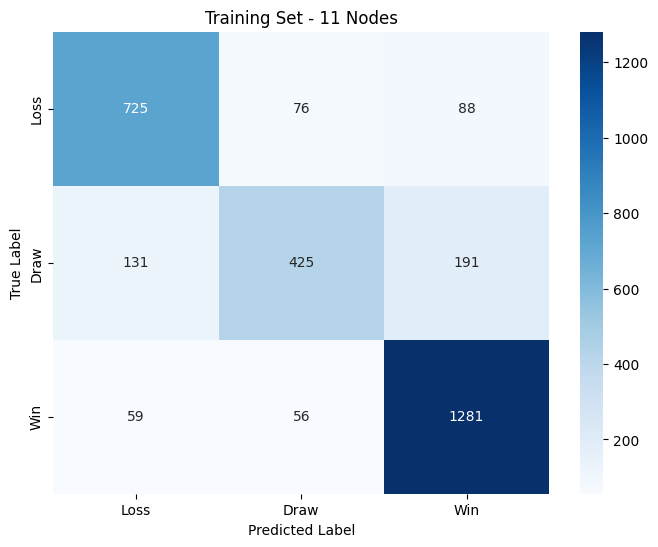

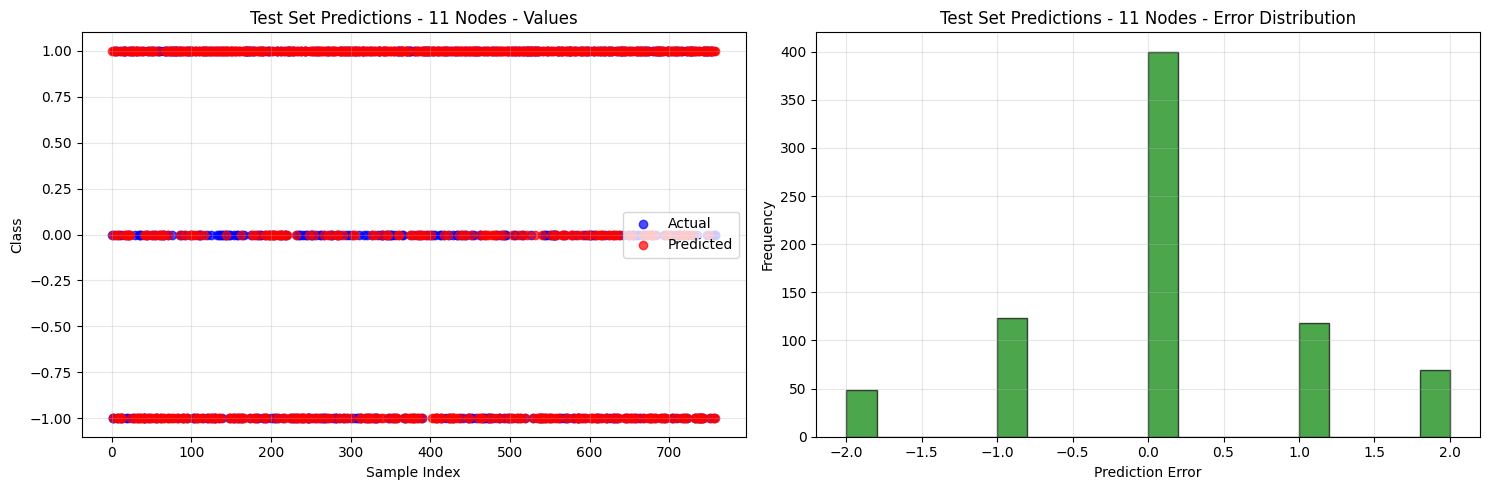


──────────────────────────────────────────────────
Training with 12 hidden nodes
──────────────────────────────────────────────────
TEST SET - 12 nodes:

RESULTS FOR TEST SET (12 NODES)
Overall Accuracy: 0.5283

Confusion Matrix:
[[105  27  79]
 [ 62  37  94]
 [ 48  48 259]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.49      0.50      0.49       211
        Draw       0.33      0.19      0.24       193
         Win       0.60      0.73      0.66       355

    accuracy                           0.53       759
   macro avg       0.47      0.47      0.46       759
weighted avg       0.50      0.53      0.51       759


Per-class Accuracy:
  Loss: 0.4976
  Draw: 0.1917
  Win: 0.7296


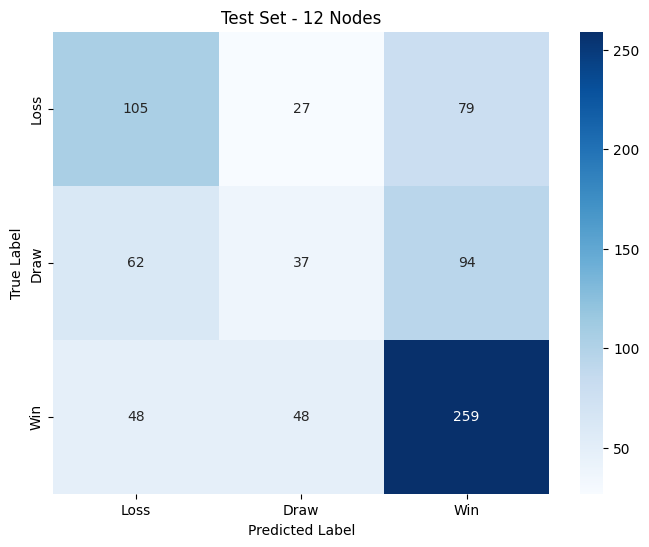


TRAINING SET - 12 nodes:

RESULTS FOR TRAINING SET (12 NODES)
Overall Accuracy: 0.8044

Confusion Matrix:
[[ 750   40   99]
 [  87  448  212]
 [  78   77 1241]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.82      0.84      0.83       889
        Draw       0.79      0.60      0.68       747
         Win       0.80      0.89      0.84      1396

    accuracy                           0.80      3032
   macro avg       0.80      0.78      0.79      3032
weighted avg       0.80      0.80      0.80      3032


Per-class Accuracy:
  Loss: 0.8436
  Draw: 0.5997
  Win: 0.8890


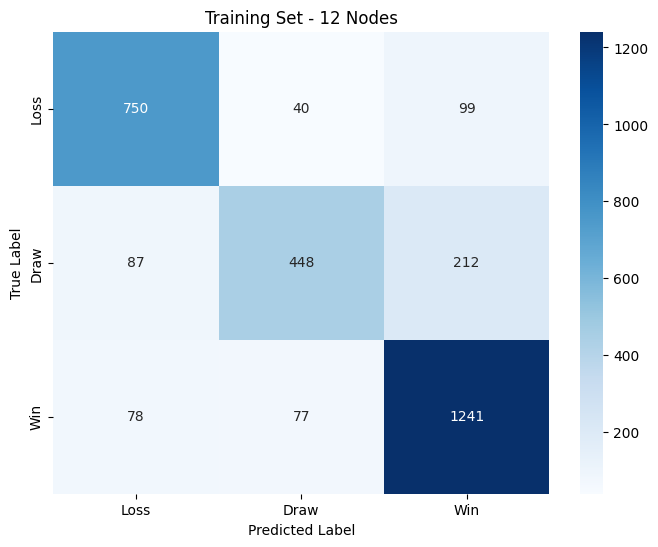

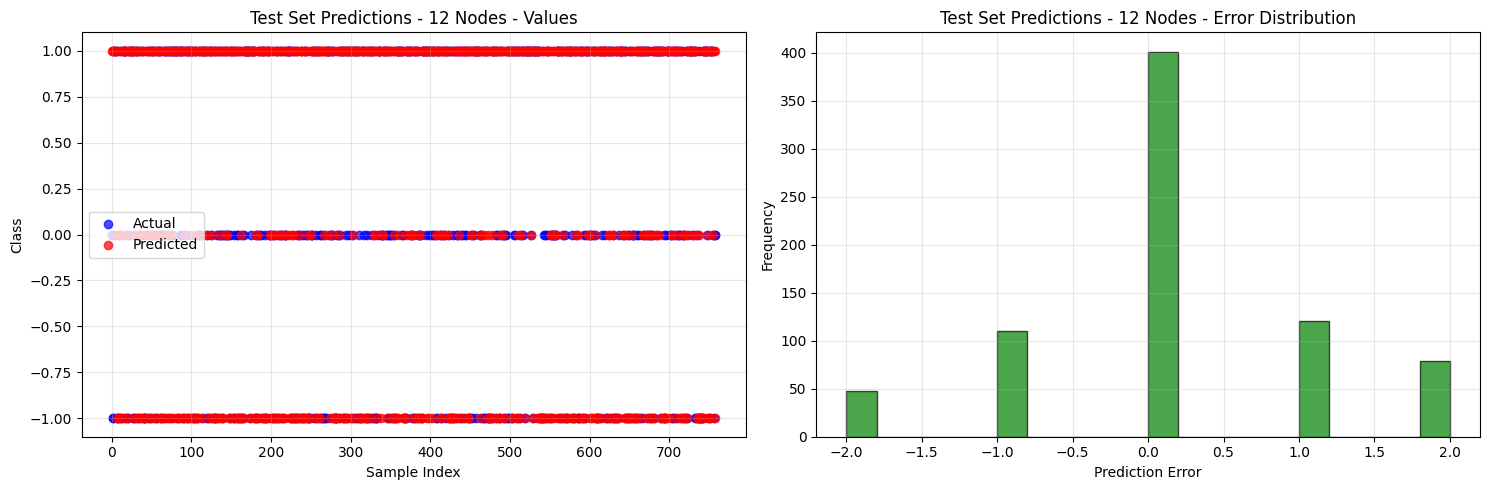


──────────────────────────────────────────────────
Training with 13 hidden nodes
──────────────────────────────────────────────────
TEST SET - 13 nodes:

RESULTS FOR TEST SET (13 NODES)
Overall Accuracy: 0.5389

Confusion Matrix:
[[107  33  71]
 [ 64  46  83]
 [ 52  47 256]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.48      0.51      0.49       211
        Draw       0.37      0.24      0.29       193
         Win       0.62      0.72      0.67       355

    accuracy                           0.54       759
   macro avg       0.49      0.49      0.48       759
weighted avg       0.52      0.54      0.52       759


Per-class Accuracy:
  Loss: 0.5071
  Draw: 0.2383
  Win: 0.7211


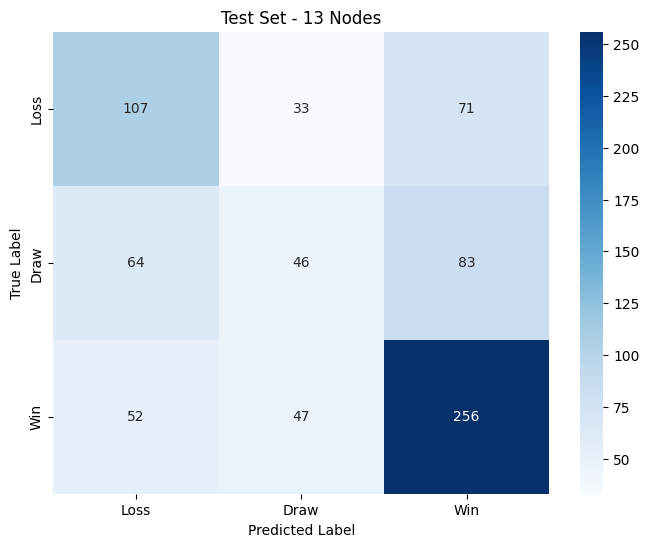


TRAINING SET - 13 nodes:

RESULTS FOR TRAINING SET (13 NODES)
Overall Accuracy: 0.8371

Confusion Matrix:
[[ 759   44   86]
 [  91  487  169]
 [  47   57 1292]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.85      0.85      0.85       889
        Draw       0.83      0.65      0.73       747
         Win       0.84      0.93      0.88      1396

    accuracy                           0.84      3032
   macro avg       0.84      0.81      0.82      3032
weighted avg       0.84      0.84      0.83      3032


Per-class Accuracy:
  Loss: 0.8538
  Draw: 0.6519
  Win: 0.9255


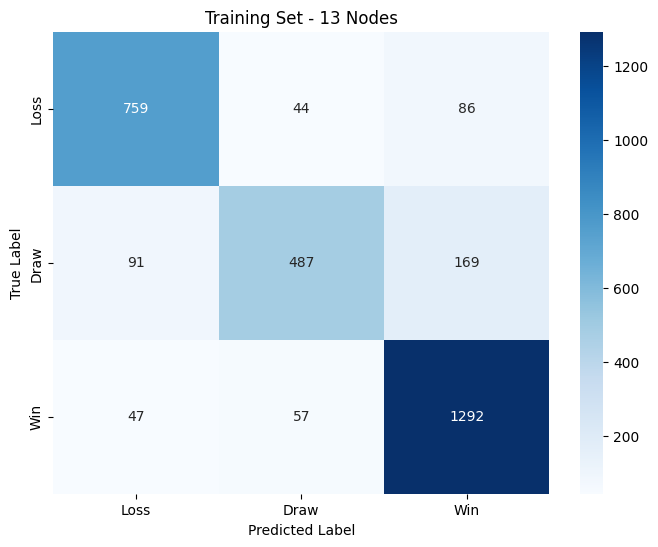

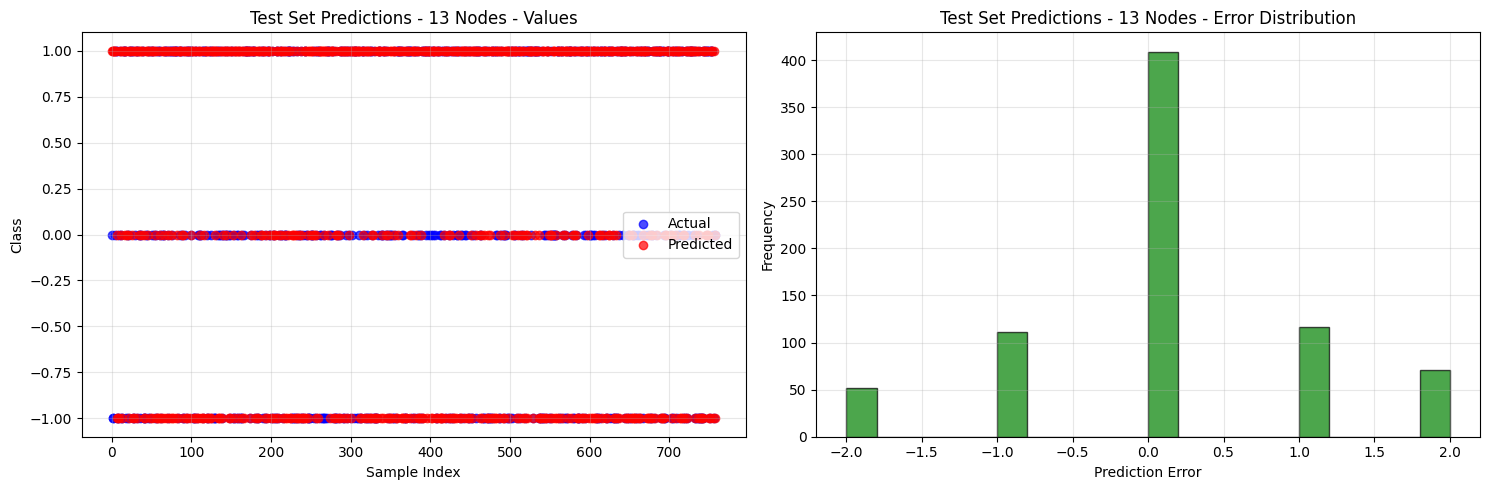


──────────────────────────────────────────────────
Training with 14 hidden nodes
──────────────────────────────────────────────────
TEST SET - 14 nodes:

RESULTS FOR TEST SET (14 NODES)
Overall Accuracy: 0.5468

Confusion Matrix:
[[113  28  70]
 [ 56  44  93]
 [ 43  54 258]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.53      0.54      0.53       211
        Draw       0.35      0.23      0.28       193
         Win       0.61      0.73      0.66       355

    accuracy                           0.55       759
   macro avg       0.50      0.50      0.49       759
weighted avg       0.52      0.55      0.53       759


Per-class Accuracy:
  Loss: 0.5355
  Draw: 0.2280
  Win: 0.7268


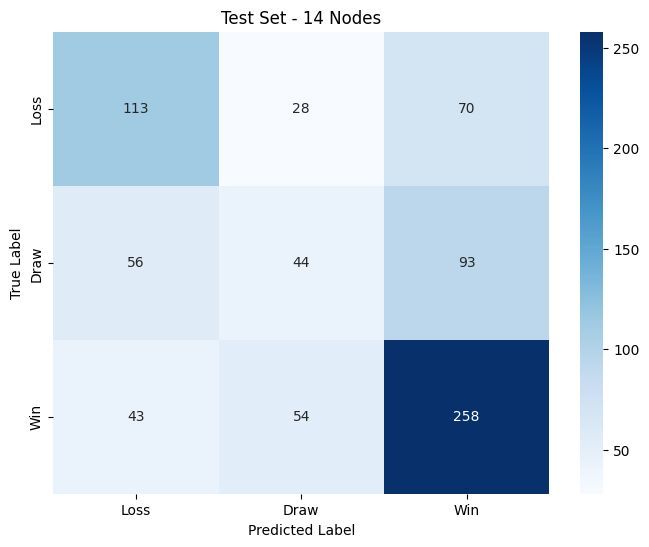


TRAINING SET - 14 nodes:

RESULTS FOR TRAINING SET (14 NODES)
Overall Accuracy: 0.8440

Confusion Matrix:
[[ 755   56   78]
 [ 111  490  146]
 [  45   37 1314]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.83      0.85      0.84       889
        Draw       0.84      0.66      0.74       747
         Win       0.85      0.94      0.90      1396

    accuracy                           0.84      3032
   macro avg       0.84      0.82      0.82      3032
weighted avg       0.84      0.84      0.84      3032


Per-class Accuracy:
  Loss: 0.8493
  Draw: 0.6560
  Win: 0.9413


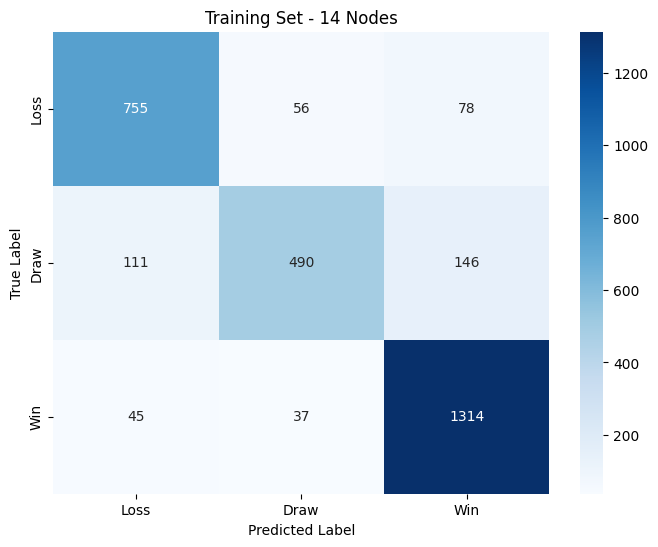

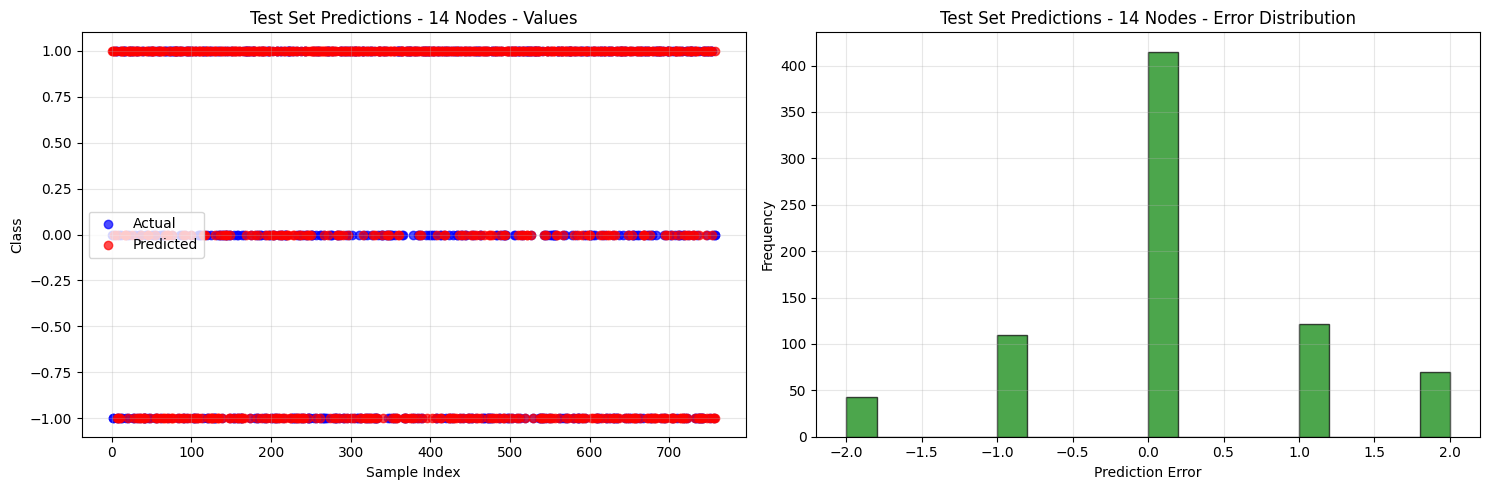


──────────────────────────────────────────────────
Training with 15 hidden nodes
──────────────────────────────────────────────────
TEST SET - 15 nodes:

RESULTS FOR TEST SET (15 NODES)
Overall Accuracy: 0.5165

Confusion Matrix:
[[103  43  65]
 [ 57  42  94]
 [ 56  52 247]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.48      0.49      0.48       211
        Draw       0.31      0.22      0.25       193
         Win       0.61      0.70      0.65       355

    accuracy                           0.52       759
   macro avg       0.46      0.47      0.46       759
weighted avg       0.50      0.52      0.50       759


Per-class Accuracy:
  Loss: 0.4882
  Draw: 0.2176
  Win: 0.6958


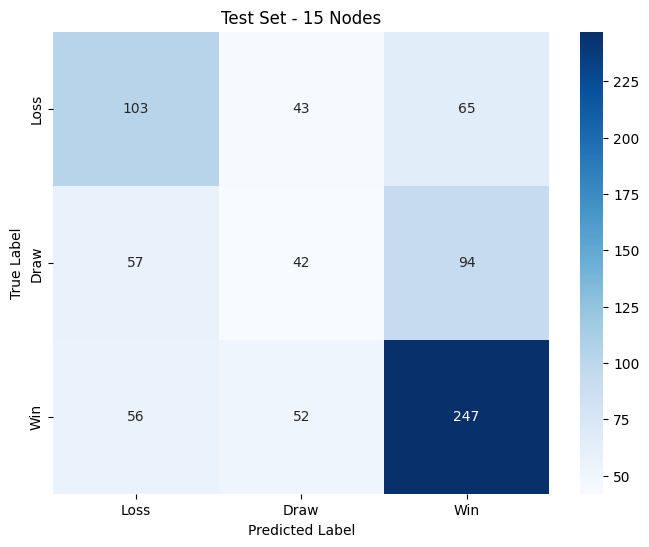


TRAINING SET - 15 nodes:

RESULTS FOR TRAINING SET (15 NODES)
Overall Accuracy: 0.8377

Confusion Matrix:
[[ 767   61   61]
 [  96  468  183]
 [  39   52 1305]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.85      0.86      0.86       889
        Draw       0.81      0.63      0.70       747
         Win       0.84      0.93      0.89      1396

    accuracy                           0.84      3032
   macro avg       0.83      0.81      0.82      3032
weighted avg       0.84      0.84      0.83      3032


Per-class Accuracy:
  Loss: 0.8628
  Draw: 0.6265
  Win: 0.9348


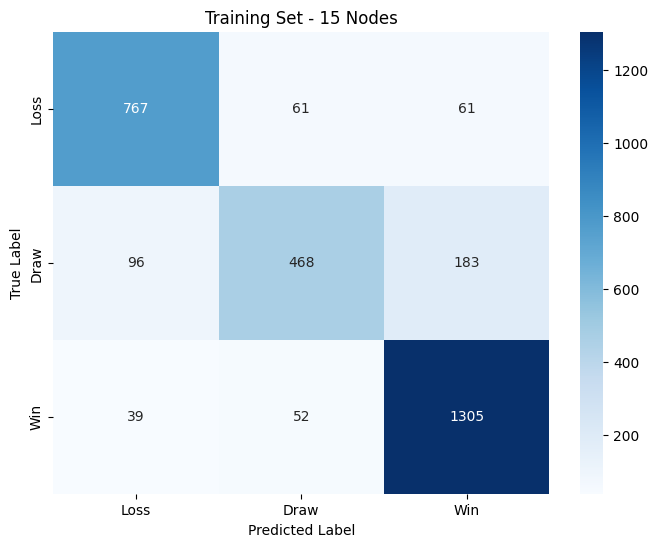

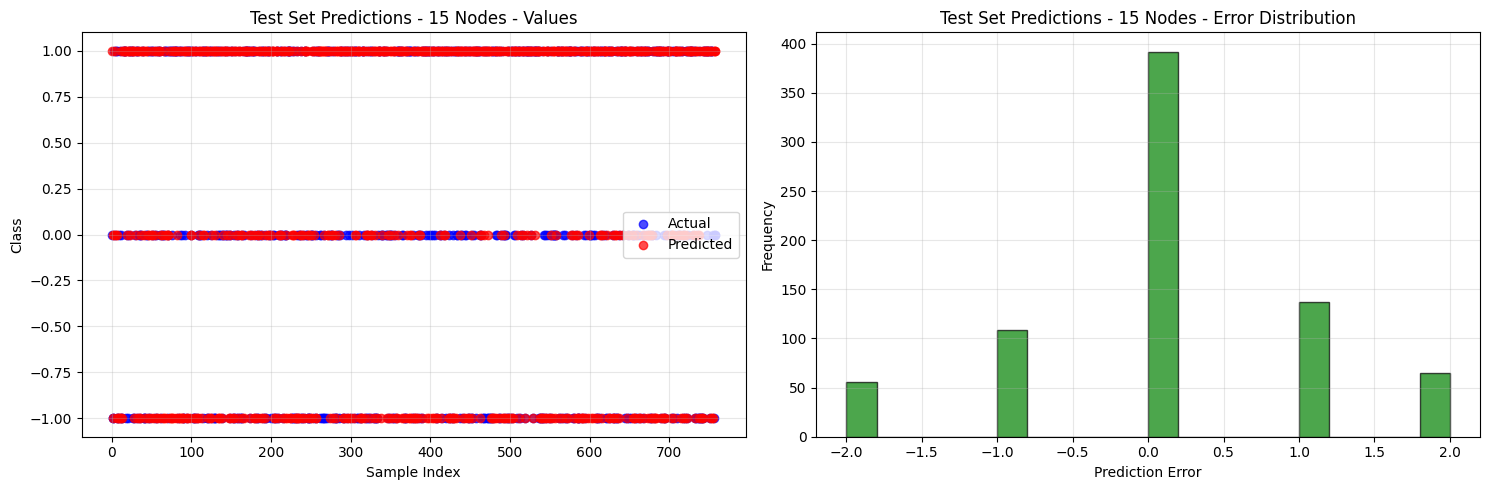


──────────────────────────────────────────────────
Training with 16 hidden nodes
──────────────────────────────────────────────────
TEST SET - 16 nodes:

RESULTS FOR TEST SET (16 NODES)
Overall Accuracy: 0.5231

Confusion Matrix:
[[107  36  68]
 [ 58  43  92]
 [ 55  53 247]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.49      0.51      0.50       211
        Draw       0.33      0.22      0.26       193
         Win       0.61      0.70      0.65       355

    accuracy                           0.52       759
   macro avg       0.47      0.48      0.47       759
weighted avg       0.50      0.52      0.51       759


Per-class Accuracy:
  Loss: 0.5071
  Draw: 0.2228
  Win: 0.6958


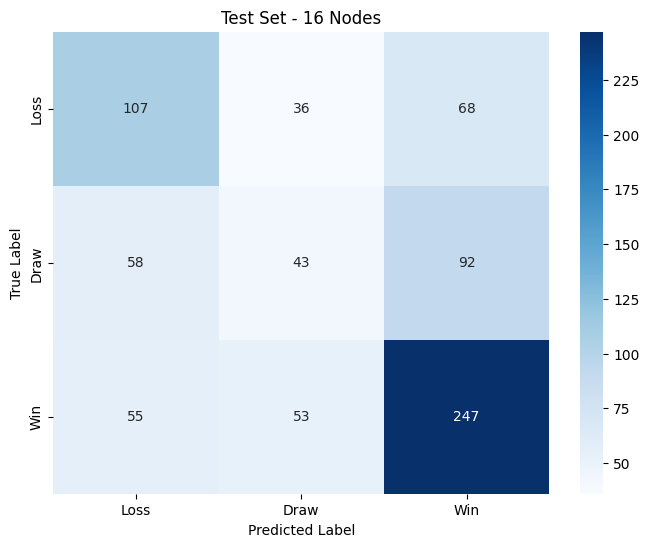


TRAINING SET - 16 nodes:

RESULTS FOR TRAINING SET (16 NODES)
Overall Accuracy: 0.8631

Confusion Matrix:
[[ 774   46   69]
 [  88  538  121]
 [  46   45 1305]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.85      0.87      0.86       889
        Draw       0.86      0.72      0.78       747
         Win       0.87      0.93      0.90      1396

    accuracy                           0.86      3032
   macro avg       0.86      0.84      0.85      3032
weighted avg       0.86      0.86      0.86      3032


Per-class Accuracy:
  Loss: 0.8706
  Draw: 0.7202
  Win: 0.9348


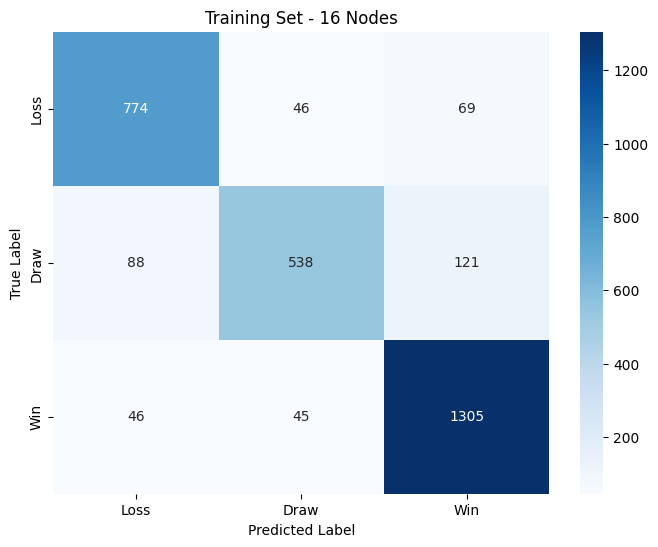

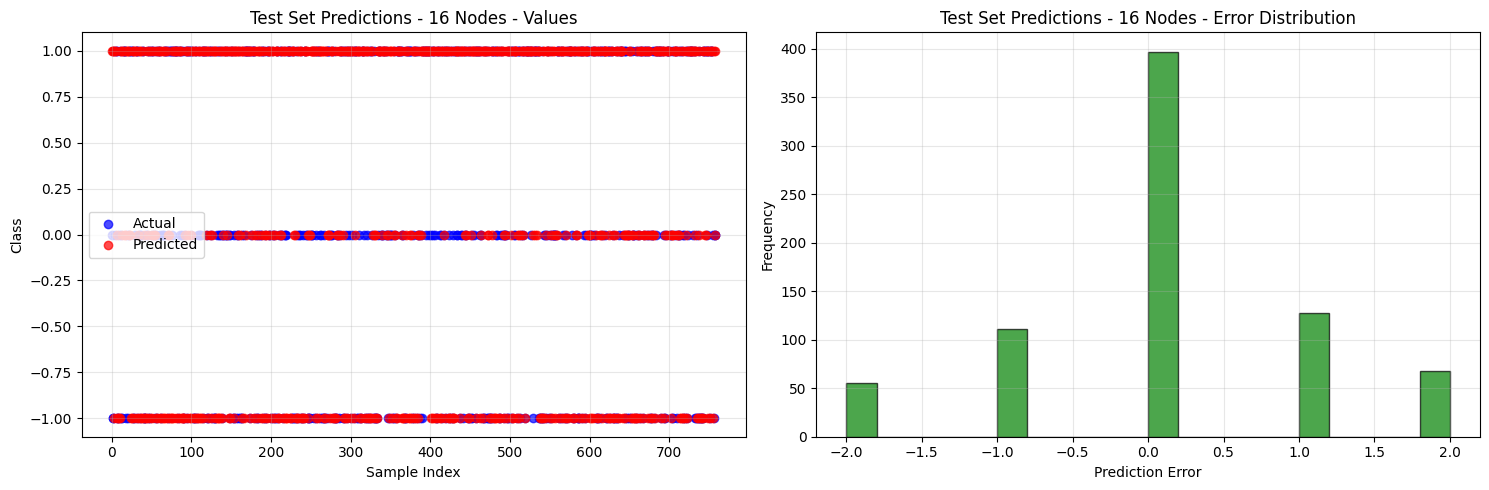


──────────────────────────────────────────────────
Training with 17 hidden nodes
──────────────────────────────────────────────────
TEST SET - 17 nodes:

RESULTS FOR TEST SET (17 NODES)
Overall Accuracy: 0.5257

Confusion Matrix:
[[105  35  71]
 [ 57  46  90]
 [ 47  60 248]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.50      0.50      0.50       211
        Draw       0.33      0.24      0.28       193
         Win       0.61      0.70      0.65       355

    accuracy                           0.53       759
   macro avg       0.48      0.48      0.47       759
weighted avg       0.51      0.53      0.51       759


Per-class Accuracy:
  Loss: 0.4976
  Draw: 0.2383
  Win: 0.6986


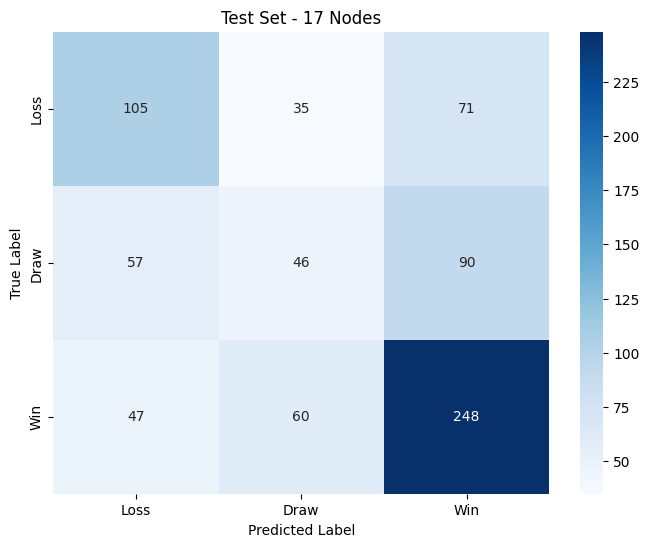


TRAINING SET - 17 nodes:

RESULTS FOR TRAINING SET (17 NODES)
Overall Accuracy: 0.8773

Confusion Matrix:
[[ 783   41   65]
 [  69  551  127]
 [  40   30 1326]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.88      0.88      0.88       889
        Draw       0.89      0.74      0.80       747
         Win       0.87      0.95      0.91      1396

    accuracy                           0.88      3032
   macro avg       0.88      0.86      0.86      3032
weighted avg       0.88      0.88      0.88      3032


Per-class Accuracy:
  Loss: 0.8808
  Draw: 0.7376
  Win: 0.9499


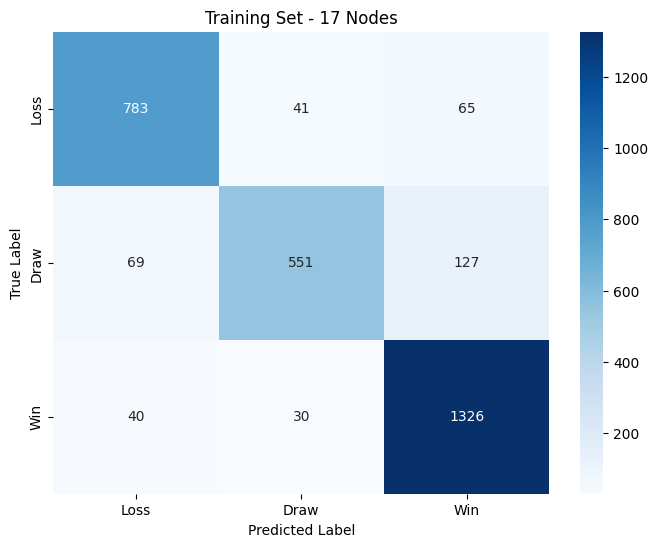

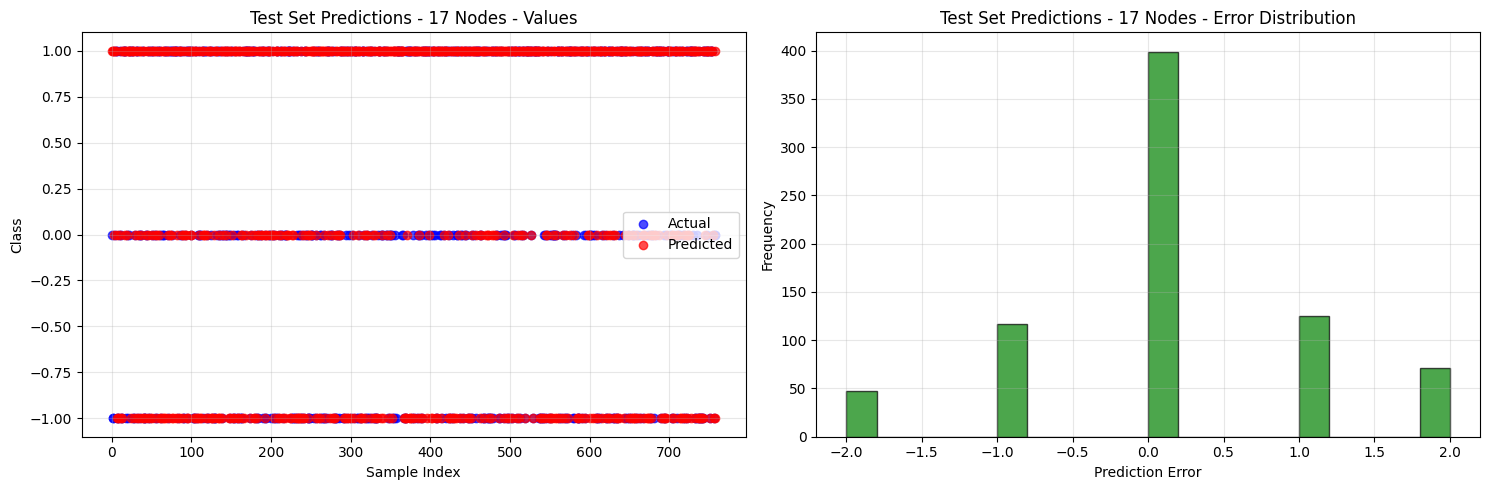


──────────────────────────────────────────────────
Training with 18 hidden nodes
──────────────────────────────────────────────────
TEST SET - 18 nodes:

RESULTS FOR TEST SET (18 NODES)
Overall Accuracy: 0.5217

Confusion Matrix:
[[108  31  72]
 [ 59  44  90]
 [ 53  58 244]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.49      0.51      0.50       211
        Draw       0.33      0.23      0.27       193
         Win       0.60      0.69      0.64       355

    accuracy                           0.52       759
   macro avg       0.47      0.48      0.47       759
weighted avg       0.50      0.52      0.51       759


Per-class Accuracy:
  Loss: 0.5118
  Draw: 0.2280
  Win: 0.6873


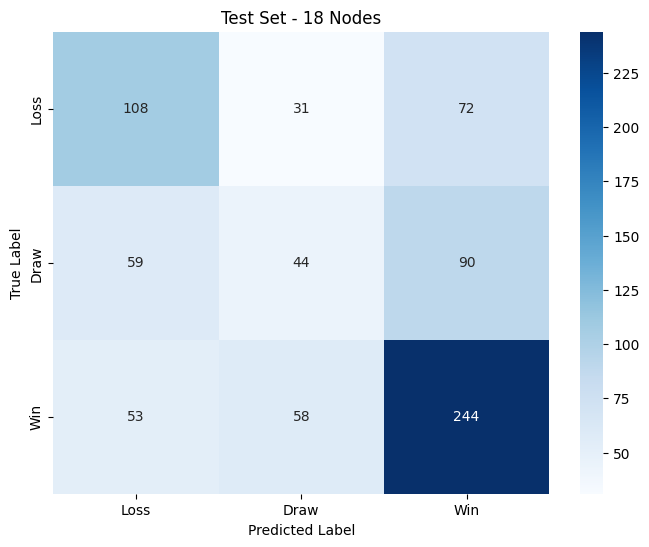


TRAINING SET - 18 nodes:

RESULTS FOR TRAINING SET (18 NODES)
Overall Accuracy: 0.8816

Confusion Matrix:
[[ 788   41   60]
 [  78  554  115]
 [  37   28 1331]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.87      0.89      0.88       889
        Draw       0.89      0.74      0.81       747
         Win       0.88      0.95      0.92      1396

    accuracy                           0.88      3032
   macro avg       0.88      0.86      0.87      3032
weighted avg       0.88      0.88      0.88      3032


Per-class Accuracy:
  Loss: 0.8864
  Draw: 0.7416
  Win: 0.9534


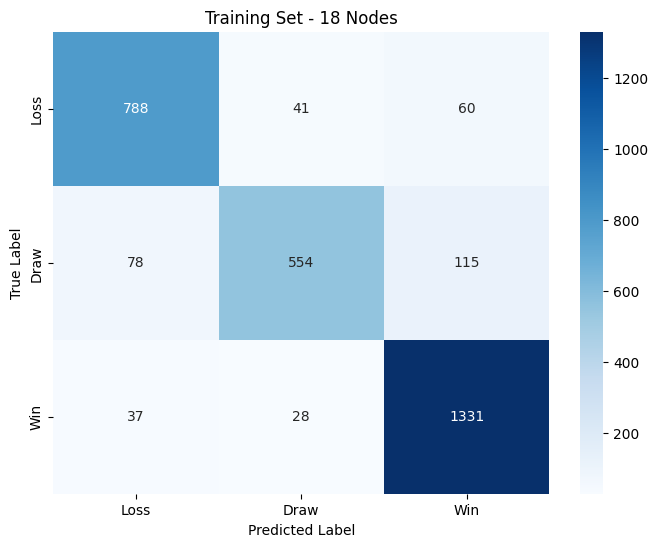

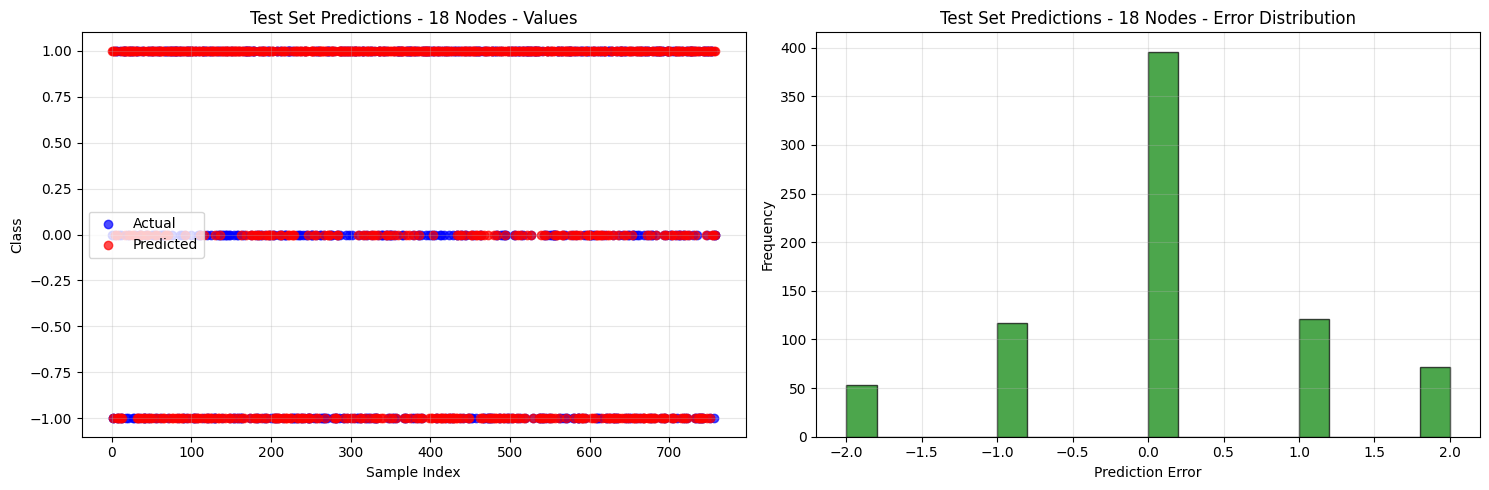


──────────────────────────────────────────────────
Training with 19 hidden nodes
──────────────────────────────────────────────────
TEST SET - 19 nodes:

RESULTS FOR TEST SET (19 NODES)
Overall Accuracy: 0.5217

Confusion Matrix:
[[106  42  63]
 [ 59  43  91]
 [ 51  57 247]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.49      0.50      0.50       211
        Draw       0.30      0.22      0.26       193
         Win       0.62      0.70      0.65       355

    accuracy                           0.52       759
   macro avg       0.47      0.47      0.47       759
weighted avg       0.50      0.52      0.51       759


Per-class Accuracy:
  Loss: 0.5024
  Draw: 0.2228
  Win: 0.6958


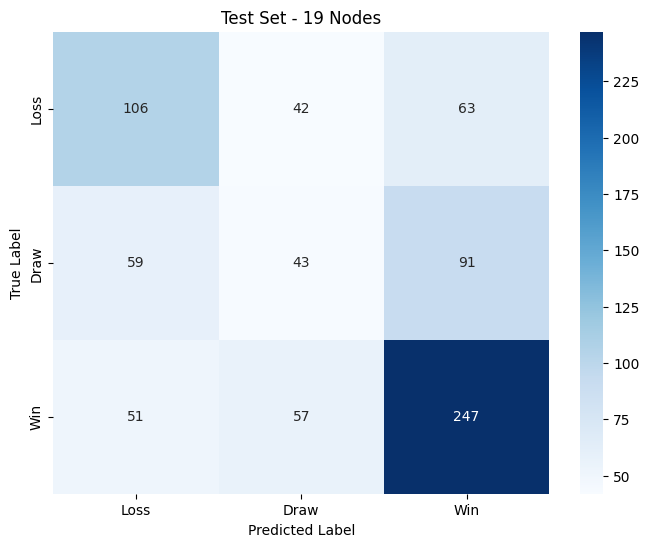


TRAINING SET - 19 nodes:

RESULTS FOR TRAINING SET (19 NODES)
Overall Accuracy: 0.8869

Confusion Matrix:
[[ 789   48   52]
 [  72  563  112]
 [  37   22 1337]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Loss       0.88      0.89      0.88       889
        Draw       0.89      0.75      0.82       747
         Win       0.89      0.96      0.92      1396

    accuracy                           0.89      3032
   macro avg       0.89      0.87      0.87      3032
weighted avg       0.89      0.89      0.88      3032


Per-class Accuracy:
  Loss: 0.8875
  Draw: 0.7537
  Win: 0.9577


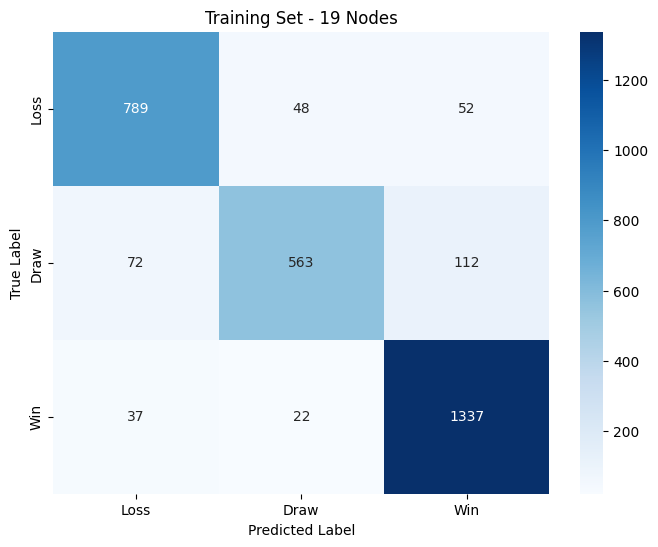

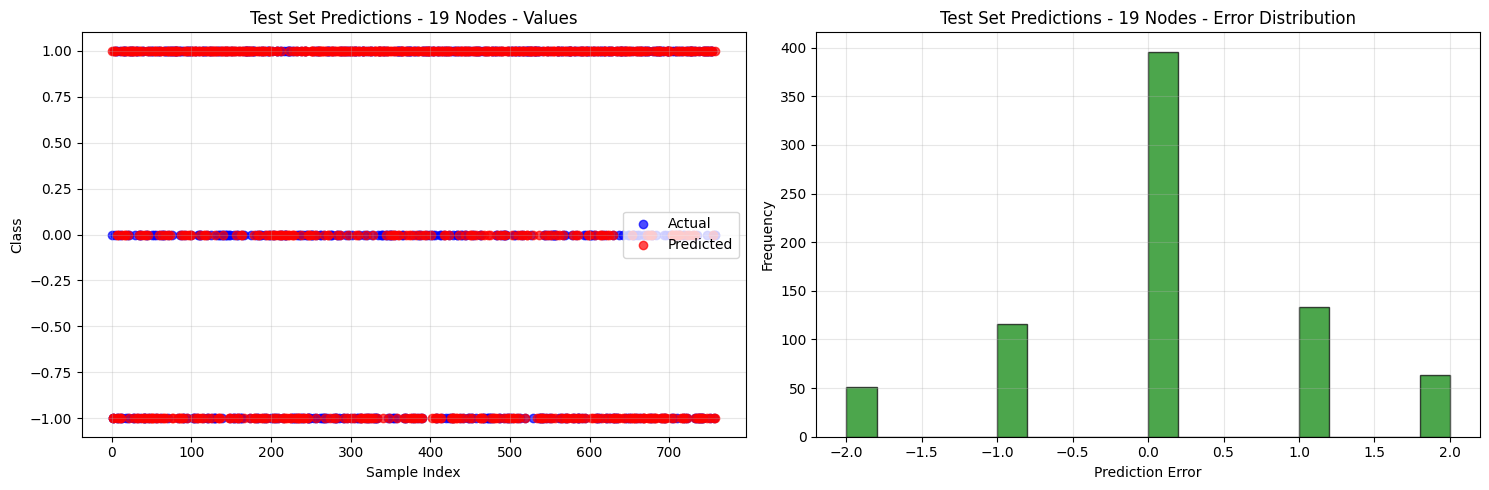

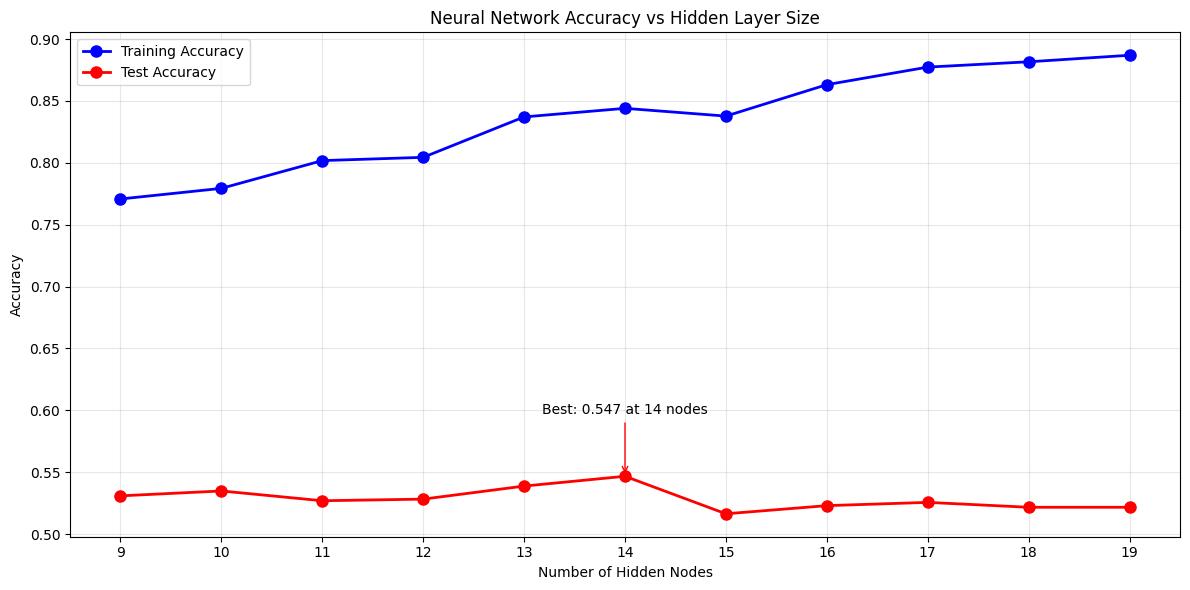


FINAL SUMMARY
Best Model: 14 hidden nodes
Best Test Accuracy: 0.5468
Training Accuracy Range: 0.7708 - 0.8869
Test Accuracy Range: 0.5165 - 0.5468
Overfitting Gap: 0.3401
⚠️  Warning: Potential overfitting detected!

ANALYSIS COMPLETED SUCCESSFULLY!


In [14]:
# Cell 7: Run the Analysis
if __name__ == '__main__':
    print("Starting Neural Network Analysis for EPL Predictions")
    print("="*60)
    
    best_model, scaler, train_acc, test_acc = main(data_extended_name)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*60)